## First we need to import our libraries.  
math is for calculating logarithms  
pandas is for working with the csv file of training data  
graphviz is for visualizing the decision tree

In [1]:
import numpy as np
import math
import pandas as pd
import itertools
from graphviz import Graph

## Formula for entropy of a set
$$Entropy(S) = - {p_{(+)}} \log_2{p_{(+)}} - {p_{(-)}} \log_2{p_{(-)}}$$

In [2]:
def calc_entropy(S):
    """Calculate entropy of a set
    
    Arguments:
    S -- set as list [pos, neg],
    where pos is number of positive entries in set
    and neg is number of negative entries in set
    
    Output:
    Entropy from 0 to 1
    """
    
    if 0 in S:
        return 0
    else:
        S = np.array(S)
        return -np.sum(S/np.sum(S)*np.log2(S/np.sum(S)))

## Formula for gain of a set and attribute
$$Gain(S, A) = Entropy(S) -\sum_{v \subseteq Values(A)} \frac{|S_v|} {|S|} Entropy(S_v)$$

In [3]:
def calc_gain(S, A):
    """Calculate information gain from attribute of a set
    
    Arguments:
    S -- outcome set as list [pos, neg],
    where pos is number of positive entries in set
    and neg is number of negative entries in set
    A -- attribute set as list [[pos, neg], [pos, neg], ...]
    where A is a subset of set S,
    each pair of pos and neg represent the outcome based on the value of the attribute
    and pos is number of positive entries in set
    and neg is number of negative entries in set
    
    Output:
    Information gain
    """

    A = np.array(A)
    return calc_entropy(S) - np.sum(np.apply_along_axis(calc_entropy, 1, A)*np.sum(A, axis=1)/np.sum(S))

## Formula for split information of a set and attribute
$$SplitInformation(S, A) = -\sum_{v \subseteq Values(A)} \frac{|S_v|} {|S|} \log_2{\frac{|S_v|} {|S|}}$$

In [4]:
def calc_split_info(S, A):
    """Calculate split information from attribute of a set
    
    Arguments:
    S -- outcome set as list [pos, neg],
    where pos is number of positive entries in set
    and neg is number of negative entries in set
    A -- attribute set as list [[pos, neg], [pos, neg], ...]
    where A is a subset of set S,
    each pair of pos and neg represent the outcome based on the value of the attribute
    and pos is number of positive entries in set
    and neg is number of negative entries in set
    
    Output:
    Split information
    """

    A = np.array(A)
    return np.sum(-np.sum(A, 1)/np.sum(S)*np.log2(np.sum(A, 1)/np.sum(S)))

## Formula for gain ratio of a set and attribute
$$GainRatio(S, A) = \frac{Gain(S, A)} {SplitInformation(S, A)}$$

In [5]:
def calc_gain_ratio(S, A):
    """Calculate gain ratio from attribute of a set
    
    Arguments:
    S -- outcome set as list [pos, neg],
    where pos is number of positive entries in set
    and neg is number of negative entries in set
    A -- attribute set as list [[pos, neg], [pos, neg], ...]
    where A is a subset of set S,
    each pair of pos and neg represent the outcome based on the value of the attribute
    and pos is number of positive entries in set
    and neg is number of negative entries in set
    
    Output:
    Gain ratio
    """
    
    split_info = calc_split_info(S, A)
    if split_info == 0:
        return 0
    else:
        return calc_gain(S, A) / split_info

## Formula for determining split attriubte using gain ratio
$$maxGainRatio = max([GainRatio(S, A_i) \ for \ i=1:n]) \ where \ n=number \ of \ attributes$$  
$$splitAttribute =  [GainRatio(S, A_i) \ for \ i=1:n]).indexOf(maxGainRatio) \ where \ n=number \ of \ attributes$$

## Formula for determing split attribute using gain
$$maxGain = max([Gain(S, A_i) \ for \ i=1:n]) \ where \ n=number \ of \ attributes$$  
$$splitAttribute =  [Gain(S, A_i) \ for \ i=1:n]).indexOf(maxGain) \ where \ n=number \ of \ attributes$$

In [6]:
def calc_split_att(S, attributes, values, method='gain_ratio'):
    """Calculate the attribute on which to split
    
    Arguments:
    S -- outcome set as list [pos, neg],
    where pos is number of positive entries in set
    and neg is number of negative entries in set
    A_n -- entire attribute set as list [[[pos, neg], [pos, neg], ...], 
                                         [[pos, neg], [pos, neg], ...], 
                                         [[pos, neg], [pos, neg], ...]]
    where A_n is a subset of of all attributes of set S,
    each row represents a single attribute and its outcomes
    each pair of pos and neg represent the outcome based on the value of the attribute
    and pos is number of positive entries in set for each attribute
    and neg is number of negative entries in set for each attribute
    method -- calculation method to use (default gain_ratio)
    
    Output:
    Attribute on which to split
    """
    
    if method == 'gain_ratio':
        index = np.argmax(list(map(calc_gain_ratio, itertools.repeat(S, len(values)), values)))
        return attributes[index][0], index
    
    else:
        index = np.argmax(list(map(calc_gain, itertools.repeat(S, len(values)), values)))
        return attributes[index][0], index

## Data preprocessing to convert tabular data to proper format for calculations  
Outcome data is conveted to list in form [pos, neg]  
&nbsp;&nbsp;&nbsp;&nbsp;[9, 5]  
Attribute data is converted to nested dictionary, with outer dictionary containing attributes as keys and inner dictionary containing attribute values as keys and attribute positive and negative counts as lists  
&nbsp;&nbsp;&nbsp;&nbsp;{'Humidity': {'High': [3, 4], 'Normal': [6, 1]},  
&nbsp;&nbsp;&nbsp;&nbsp;'Outlook': {'Overcast': [4, 0], 'Rain': [3, 2], 'Sunny': [2, 3]},  
&nbsp;&nbsp;&nbsp;&nbsp;'Temperature': {'Cool': [3, 1], 'Hot': [2, 2], 'Mild': [4, 2]},  
&nbsp;&nbsp;&nbsp;&nbsp;'Wind': {'Strong': [3, 3], 'Weak': [6, 2]}}  

In [7]:
def data_prep(data):
    """Format data into target set and attribute sets
    
    Arguments:
    data -- DataFrame of training data
    
    Output:
    S -- outcome set as list [pos, neg],
    where pos is number of positive entries in set
    and neg is number of negative entries in set
    A_n -- nested dictionary with outer dictionary containing attributes as keys
    inner dictionary containing values of attributes as keys and
    associated value of key-value pair being the pos and neg counts, see below
    {'Humidity': {'High': [3, 4], 'Normal': [6, 1]},
     'Outlook': {'Overcast': [4, 0], 'Rain': [3, 2], 'Sunny': [2, 3]},
     'Temperature': {'Cool': [3, 1], 'Hot': [2, 2], 'Mild': [4, 2]},
     'Wind': {'Strong': [3, 3], 'Weak': [6, 2]}}
    """
    
    attributes = []
    values = []
    for i, col in enumerate(data.iloc[:, :-1].columns):
        attributes.append([col, list(set(data[col]))])
        temp = []
        for val in attributes[i][1]:
            pos = data[data[col]==val].iloc[:, -1].sum()
            neg = data[data[col]==val].iloc[:, -1].count() - pos
            temp.append([pos, neg])
        values.append(temp)

    pos = data.iloc[:, -1].sum()
    neg = data.iloc[:, -1].count() - pos
    S = [pos, neg]
    return S, attributes, values

## Node class to represent nodes of decision tree
Each node contains the following properties:
- value: 0 or 1
- parent: parent node
- children: list of child nodes

In [8]:
class Node:
    """Node class to represent nodes of decision tree
    
    Attributes:
    name
    parent
    children
    value
    
    Methods:
    __init()__
    set_value()
    set_parent()
    set_children()
    """

    def __init__(self, name, parent=None, value=None):
        """Constructor method for Node class

        Arguments:
        name -- name of Node
        parent -- parent of Node (default None)
        value -- value of Node (default None)
        
        Also initializes children to []
        """
        
        self.name = name
        self.parent = parent
        self.children = []
        self.value = value
        
    def set_value(self, value):
        """Setter method for value property

        Arguments:
        value -- value of Node
        """
        
        self.value = value
        
    def set_parent(self, parent):
        """Setter method for parent property

        Arguments:
        parent -- parent of Node
        """
        
        self.parent = parent
        
    def set_children(self, child):
        """Setter method for children property

        Arguments:
        child -- child of Node
        """
        
        self.children.append(child)

## ID3 class to represent decision tree
Each ID3 contains the following properties:
- data: DataFrame used for training ID3 tree
- tree: decision tree made up of Nodes

In [9]:
class ID3:
    """ID3 class to represent decision tree
    
    Attributes:
    data
    tree
    
    Methods:
    __init()__
    train()
    predict()
    """
    
    def __init__(self, data):
        """Constructor method for ID3 class

        Arguments:
        data -- DataFrame of data to be used for training
        """       
        
        self.data = data
        
    def train(self, method='gain_ratio'):
        """Train ID3 tree
    
        Arguments:
        None

        Output:
        None
        
        Attributes:
        tree -- sets property tree to ID3 tree
        """
        
        def id3(data, method='gain_ratio'):
            """Nested recursive function to build ID3 tree

            Arguments:
            data -- DataFrame of training data

            Output:
            parent -- root node of ID3 tree with all children assigned
            """
            
            if data.iloc[:, -1].mean() in [0, 1]:
                return Node('Target', None, data.iloc[:, -1].mean())
            else:
                S, attributes, values = data_prep(data)
                attribute, index = calc_split_att(S, attributes, values, method)
                parent = Node(attribute)
                for i, att in enumerate(attributes[index][1]):
                    if 0 in values[index][i]:
                        parent.set_children(Node(att, parent, values[index][i].index(0)))
                    else:
                        child = Node(att, parent, None)
                        parent.set_children(child)
                        child.set_children(id3(data[data[parent.name]==child.name]))
                return parent
        
        self.tree = id3(self.data)
        
    def predict(self, test):
        """Predicts an outcome on new data
    
        Arguments:
        test -- DataFrame of test data without known outcome

        Output:
        prediction -- 0 or 1
        path -- path taken from root to leaf node to obtain prediciton
        """
                
        path = [self.tree.name]
        tree = self.tree
        while tree.value == None:
            if tree.name in test.columns:
                for child in tree.children:
                    if child.name in test[tree.name].values:
                        path.append(child.name)
                        tree = child
                        break
            else:
                path.append(tree.children[0].name)
                tree = tree.children[0]
            
        return tree.value, path

## Method to plot decision tree as graph object
Takes tree object as input and returns graph object

In [10]:
def plot_tree(tree):
    """Plot decision tree
    
    Arguments:
    tree -- ID3 decision tree
    
    Output:
    graph -- undirected graph with leaf nodes
    representing decision to play or not
    """
    
    def plot_tree_aux(tree, graph):
        """Nested method to plot decision tree

        Arguments:
        tree -- ID3 decision tree
        graph -- Graph object with only root node of tree

        Output:
        graph -- undirected graph with leaf nodes
        representing decision to play or not
        """
        
        if tree.children == []:
            graph.node(tree.name + str(tree.value), str(tree.value))
            graph.edge(tree.name, tree.name + str(tree.value))
        else:
            for child in tree.children:
                graph.node(child.name, child.name)
                graph.edge(tree.name, child.name)
                plot_tree_aux(child, graph)
        return graph
    
    graph = Graph()
    graph.node(tree.name, tree.name)
    return plot_tree_aux(tree, graph)

In [11]:
def play(pred):
    if pred == 0:
        print('Based on these conditions, we WOULD NOT recommend playing tennis today.')
    else:
        print('Based on these conditions, we WOULD recommend playing tennis today.')

## Read in data and display

In [12]:
data = pd.read_csv('tennis.csv')
data

,Outlook,Temperature,Humidity,Wind,Play
0,Sunny,Hot,High,Weak,0
1,Sunny,Hot,High,Strong,0
2,Overcast,Hot,High,Weak,1
3,Rain,Mild,High,Weak,1
4,Rain,Cool,Normal,Weak,1
5,Rain,Cool,Normal,Strong,0
6,Overcast,Cool,Normal,Strong,1
7,Sunny,Mild,High,Weak,0
8,Sunny,Cool,Normal,Weak,1
9,Rain,Mild,Normal,Weak,1


## Initialize new ID3 object with training data as input, then train ID3 object

In [15]:
id3 = ID3(data)
id3.train()

In [16]:
test = pd.DataFrame([['Rain', 'Cool', 'Normal', 'Weak']], columns=['Outlook', 'Temperature', 'Humidity', 'Wind'], index=[0])
test

,Outlook,Temperature,Humidity,Wind
0,Rain,Cool,Normal,Weak


In [17]:
pred, path = id3.predict(test)

In [18]:
play(pred)

Based on these conditions, we WOULD recommend playing tennis today.


In [19]:
path

['Outlook', 'Rain', 'Wind', 'Weak']

In [20]:
d = data.copy()

In [21]:
for i in range(0, len(path), 2):
    d = d[d[path[i]]==path[i+1]]
d

,Outlook,Temperature,Humidity,Wind,Play
3,Rain,Mild,High,Weak,1
4,Rain,Cool,Normal,Weak,1
9,Rain,Mild,Normal,Weak,1


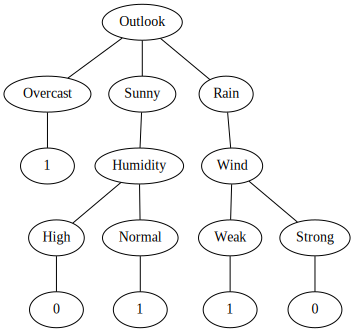

In [22]:
graph = plot_tree(id3.tree)
graph

In [23]:
id3.tree.children